In [1]:
GCS_PATH="/home/apsisdev/ansary/DATASETS/APSIS/NID/segment/"
#----------------
# imports
#---------------
import tensorflow as tf
import random
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm

import numpy as np
import matplotlib.pyplot as plt
#from kaggle_datasets import KaggleDatasets
from glob import glob
from tqdm.auto import tqdm

%matplotlib inline

Segmentation Models: using `tf.keras` framework.


In [2]:
#-------------
# GCS and files and synth
#-------------
def get_tfrecs(_path):
    gcs_pattern=os.path.join(_path,'*.tfrecord')
    file_paths = tf.io.gfile.glob(gcs_pattern)
    random.shuffle(file_paths)
    return file_paths

train_recs =[]
eval_recs=[]
# synth
#GCS_PATH = KaggleDatasets().get_gcs_path('aps-nid-segment-data')  

gcs_path=os.path.join(GCS_PATH,"tfrecords")
recs =get_tfrecs(gcs_path)
train_recs+=recs[20:]
eval_recs +=recs[:20]

print(len(eval_recs),len(train_recs))

20 91


In [3]:
#-------------------------------------------------------------
# Detect hardware, return appropriate distribution strategy
#-------------------------------------------------------------

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    tf.config.optimizer.set_jit(True)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

REPLICAS:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
#-------------------------
# train and data paras
#-----------------------
EPOCHS          = 500
if strategy.num_replicas_in_sync==1:
    BATCH_SIZE = 32
else:
    BATCH_SIZE = 16 * strategy.num_replicas_in_sync

STEPS_PER_EPOCH = (len(train_recs)*128)//BATCH_SIZE
EVAL_STEPS      = (len(eval_recs)*128)//BATCH_SIZE
print("Steps:",STEPS_PER_EPOCH)
print("Eval Steps:",EVAL_STEPS)

Steps: 364
Eval Steps: 80


In [5]:
#-------------
# data function with tf.data api
#-------------
DIM=(256,256,3)
def data_input_fn(recs): 
    '''
      This Function generates data from gcs
    '''
    
    def _parser(example):
        feature ={  'image'  : tf.io.FixedLenFeature([],tf.string),
                    'mask' : tf.io.FixedLenFeature([],tf.string),
                    'label' : tf.io.FixedLenFeature([2],tf.int64),
                    'bbox' : tf.io.FixedLenFeature([8],tf.int64)
        }     
        parsed_example=tf.io.parse_single_example(example,feature)
        # image
        image_raw=parsed_example['image']
        image=tf.image.decode_png(image_raw,channels=3)
        image=tf.cast(image,tf.float32)/255.0
        image=tf.reshape(image,DIM)
        
        # mask
        #mask=parsed_example['mask']
        #mask=tf.image.decode_png(mask,channels=1)
        #mask=tf.cast(mask,tf.float32)/255.0
        #mask=tf.reshape(mask,(DIM[0],DIM[1],1))
        
        # label
        label=parsed_example['label']
        label=tf.cast(label,tf.float32)
        # bbox
        bbox=parsed_example['bbox']
        bbox=tf.cast(bbox,tf.float32)
        
        
        outputs={"label":label,"bbox":bbox}
        return image,outputs

    dataset = tf.data.TFRecordDataset(recs)
    dataset = dataset.map(_parser)
    dataset = dataset.shuffle(2048,reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

train_ds  =   data_input_fn(train_recs)
eval_ds   =   data_input_fn(eval_recs)

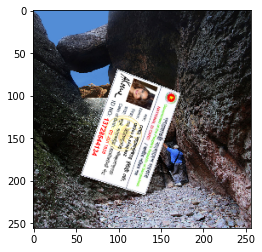

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


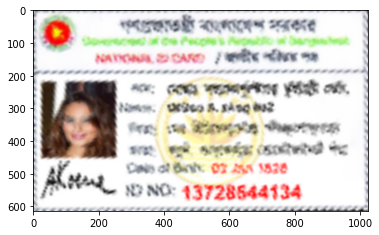

In [6]:
#-----------------------
# visual
#-----------------------
import cv2

for x,y in eval_ds.take(1):
    l=y["label"]
    # image
    data=np.squeeze(x[0])
    plt.imshow(data)
    plt.show()
    
    print(l[0])
    b=y["bbox"]
    bbox=[]
    box=b[0].numpy()
    for i in range(0,8,2):
        x,y=box[i:i+2]
        bbox.append([int(x),int(y)])
    src=np.float32(bbox)
    dst=np.float32([[0,0],[1023,0],[1023,613],[0,613]])
    M   = cv2.getPerspectiveTransform(src,dst)
    img = cv2.warpPerspective(data, M, (1024,614))
    plt.imshow(img)
    plt.show()

# Modeling

```python
```

In [7]:
def get_model(data_dim=(256,256,3),num_class=2,bbox_class=8):
    feat=tf.keras.applications.DenseNet121(input_shape=data_dim,include_top=False,
                                                   weights=None)
    inp=feat.input
    x=feat.output
    x=tf.keras.layers.GlobalAveragePooling2D()(x)
    label=tf.keras.layers.Dense(num_class,activation="softmax",name="label")(x)
    bbox =tf.keras.layers.Dense(bbox_class,name="bbox")(x)
    model=tf.keras.Model(inputs=inp,outputs=[label,bbox])
    return model

In [8]:
model=get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [9]:
#---------------
# callbacks
#---------------
# weight file path
weight_path="nid_segment.h5"

# reduces learning rate on plateau
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                                  cooldown= 10,
                                                  patience=10,
                                                  verbose =1,
                                                  min_lr=0.1e-7)
# saves the model
model_autosave = tf.keras.callbacks.ModelCheckpoint(filepath=weight_path, 
                                                   monitor='val_loss', 
                                                   verbose=1, 
                                                   save_best_only=True, 
                                                   mode='min')

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=15, 
                                                  verbose=1, 
                                                  mode = 'auto') 
callbacks= [model_autosave,lr_reducer,early_stopping]
                 
losses = {
"label":tf.keras.losses.CategoricalCrossentropy(),
"bbox":tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size')
}
#---------------
# compile
#---------------    
with strategy.scope():
    # model
    model = get_model()
    #model.load_weights("nid_segment.h5")
    # compile
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss=losses)

In [10]:
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    verbose=1, 
                    validation_data=eval_ds,
                    validation_steps=EVAL_STEPS, 
                    callbacks=callbacks)

Epoch 1/500
364/364 [==============================] - 63s 142ms/step - loss: 11905.4034 - label_loss: 0.7075 - bbox_loss: 11904.6969 - val_loss: 4290.1924 - val_label_loss: 0.8122 - val_bbox_loss: 4289.3813

Epoch 00001: val_loss improved from inf to 4290.19238, saving model to nid_segment.h5
Epoch 2/500
364/364 [==============================] - 50s 138ms/step - loss: 3055.9314 - label_loss: 0.6903 - bbox_loss: 3055.2413 - val_loss: 2350.8848 - val_label_loss: 0.8184 - val_bbox_loss: 2350.0664

Epoch 00002: val_loss improved from 4290.19238 to 2350.88477, saving model to nid_segment.h5
Epoch 3/500
364/364 [==============================] - 50s 137ms/step - loss: 526.1500 - label_loss: 0.6545 - bbox_loss: 525.4954 - val_loss: 3426.4429 - val_label_loss: 0.8074 - val_bbox_loss: 3425.6353

Epoch 00003: val_loss did not improve from 2350.88477
Epoch 4/500
364/364 [==============================] - 50s 136ms/step - loss: 282.4526 - label_loss: 0.5756 - bbox_loss: 281.8770 - val_loss: 233.

364/364 [==============================] - 49s 136ms/step - loss: 8.8926 - label_loss: 0.0095 - bbox_loss: 8.8831 - val_loss: 7.6459 - val_label_loss: 0.0032 - val_bbox_loss: 7.6427

Epoch 00032: val_loss did not improve from 5.01780
Epoch 33/500
364/364 [==============================] - 50s 137ms/step - loss: 8.0055 - label_loss: 0.0069 - bbox_loss: 7.9986 - val_loss: 8.4096 - val_label_loss: 0.0104 - val_bbox_loss: 8.3992

Epoch 00033: val_loss did not improve from 5.01780
Epoch 34/500
364/364 [==============================] - 49s 135ms/step - loss: 10.4788 - label_loss: 0.0069 - bbox_loss: 10.4719 - val_loss: 10.1124 - val_label_loss: 0.0030 - val_bbox_loss: 10.1094

Epoch 00034: val_loss did not improve from 5.01780
Epoch 35/500
364/364 [==============================] - 50s 137ms/step - loss: 8.6169 - label_loss: 0.0059 - bbox_loss: 8.6110 - val_loss: 7.1929 - val_label_loss: 0.0034 - val_bbox_loss: 7.1895

Epoch 00035: val_loss did not improve from 5.01780

Epoch 00035: ReduceL


Epoch 00063: val_loss improved from 1.45661 to 1.35101, saving model to nid_segment.h5
Epoch 64/500
364/364 [==============================] - 50s 136ms/step - loss: 1.9965 - label_loss: 0.0021 - bbox_loss: 1.9944 - val_loss: 1.4706 - val_label_loss: 0.0011 - val_bbox_loss: 1.4695

Epoch 00064: val_loss did not improve from 1.35101
Epoch 65/500
364/364 [==============================] - 50s 136ms/step - loss: 2.0529 - label_loss: 0.0019 - bbox_loss: 2.0510 - val_loss: 1.6852 - val_label_loss: 0.0011 - val_bbox_loss: 1.6841

Epoch 00065: val_loss did not improve from 1.35101
Epoch 66/500
364/364 [==============================] - 50s 136ms/step - loss: 2.0089 - label_loss: 0.0022 - bbox_loss: 2.0067 - val_loss: 1.5338 - val_label_loss: 8.6656e-04 - val_bbox_loss: 1.5329

Epoch 00066: val_loss did not improve from 1.35101
Epoch 67/500
364/364 [==============================] - 49s 136ms/step - loss: 1.8318 - label_loss: 0.0020 - bbox_loss: 1.8298 - val_loss: 1.2738 - val_label_loss: 8.8

364/364 [==============================] - 50s 139ms/step - loss: 1.2627 - label_loss: 0.0015 - bbox_loss: 1.2612 - val_loss: 1.1389 - val_label_loss: 5.5592e-04 - val_bbox_loss: 1.1383

Epoch 00095: val_loss did not improve from 1.07022
Epoch 96/500
364/364 [==============================] - 51s 140ms/step - loss: 1.3029 - label_loss: 0.0010 - bbox_loss: 1.3019 - val_loss: 1.1219 - val_label_loss: 4.4002e-04 - val_bbox_loss: 1.1215

Epoch 00096: val_loss did not improve from 1.07022
Epoch 97/500
364/364 [==============================] - 50s 137ms/step - loss: 1.0894 - label_loss: 0.0013 - bbox_loss: 1.0881 - val_loss: 1.4403 - val_label_loss: 4.2867e-04 - val_bbox_loss: 1.4399

Epoch 00097: val_loss did not improve from 1.07022
Epoch 98/500
364/364 [==============================] - 51s 139ms/step - loss: 1.1642 - label_loss: 0.0011 - bbox_loss: 1.1631 - val_loss: 1.3368 - val_label_loss: 6.6826e-04 - val_bbox_loss: 1.3361

Epoch 00098: val_loss did not improve from 1.07022
Epoch 99/

364/364 [==============================] - 50s 136ms/step - loss: 0.7495 - label_loss: 7.9580e-04 - bbox_loss: 0.7487 - val_loss: 0.8860 - val_label_loss: 3.9964e-04 - val_bbox_loss: 0.8856

Epoch 00126: val_loss did not improve from 0.88072

Epoch 00126: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 127/500
364/364 [==============================] - 50s 136ms/step - loss: 0.7244 - label_loss: 8.8616e-04 - bbox_loss: 0.7235 - val_loss: 0.9243 - val_label_loss: 4.1539e-04 - val_bbox_loss: 0.9239

Epoch 00127: val_loss did not improve from 0.88072
Epoch 128/500
364/364 [==============================] - 49s 136ms/step - loss: 0.7983 - label_loss: 8.1116e-04 - bbox_loss: 0.7975 - val_loss: 0.9493 - val_label_loss: 3.9088e-04 - val_bbox_loss: 0.9489

Epoch 00128: val_loss did not improve from 0.88072
Epoch 129/500
364/364 [==============================] - 49s 136ms/step - loss: 0.7234 - label_loss: 7.8290e-04 - bbox_loss: 0.7226 - val_loss: 0.9127 - val_label_l